In [1]:
import numpy as np
from ase.io import read, write
import matplotlib.pyplot as plt

In [2]:
def process(traj, shieldings):
    output = {}
    output_error = {}

    number = traj[0].numbers

    for species in [1,6,7,8]:
        output[species] = []
        output_error[species] = []
        types = shieldings[np.where(number == species )[0]]
        for type in np.unique(types):
            output[species].append(np.concatenate([frame.arrays['CS'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj])) 
            output_error[species].append(np.concatenate([frame.arrays['CSerr'][np.where((np.logical_and(frame.numbers==species, shieldings == type)))[0]] for frame in traj]))       
    return output, output_error

def center_shifts(s):
    elements = [1, 6, 7]
    names = ['glycine_alpha', 'glycine_beta', 'glycine_gamma']
    for el in elements:
        for name in names:
            s[name][el] = np.mean(s[name][el]) - s[name][el]
    return s

In [3]:
edgars_results = {
    'glycine_alpha': {
        1 : np.array([25.24, 26.59, 21.07]),
        6 : np.array([-8.64, 126.26]),
        7 : np.array([191.82])
    },
    'glycine_beta': {
        1: np.array([26.13, 26.91, 21.16]),
        6: np.array([-5.73, 127.86]),
        7: np.array([194.45])
    },
    'glycine_gamma': {
        1 : np.array([26.53, 27.11, 20.86]),
        6 : np.array([-5.01, 128.34]),
        7 : np.array([191.37])
    }
}

shifts = {
    'glycine_alpha': {
        1: np.array([4.2, 3.1, 8.4]),
        6: np.array([176.5, 43.4]),
        7: np.array([32.3])
    },
    'glycine_beta': {
        1: np.array([2.5, 2.2, 7.4]),
        6: np.array([175.5, 43.2]),
        7: np.array([31.8])
    },
    'glycine_gamma': {
        1: np.array([3.3, 3.1, 8.8]),
        6: np.array([174.5, 42.4]),
        7: np.array([32.9])
    }
}


shifts = center_shifts(shifts)
shifts = center_shifts(shifts)

edgars_results = center_shifts(edgars_results)

colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [16]:
# load stuff

path_to_file = "PI_NVT/glycine_shieldings/"
base_fn = lambda poly, type, average: path_to_file + f'pi_nvt_{type}_glycine_{poly}_300K_00_w_cs{average}.xyz'


#bespoke potential
lmp_traj_alpha = read(base_fn('alpha', "lmp", ""),':')
lmp_traj_gamma  = read(base_fn('gamma', "lmp", ""),':')
lmp_traj_beta = read(base_fn('beta', "lmp", ""),':')

#general potential
mlp_traj_alpha = read(base_fn('alpha', "MLP", ""),':')
mlp_traj_gamma  = read(base_fn('gamma', "MLP", ""),':')
mlp_traj_beta = read(base_fn('beta', "MLP", ""),':')

#only dftb 
mlp_traj_gamma_dftb_only  = read('PI_NVT/glycine_shieldings/pi_nvt_lmp_glycine_gamma_300K_00_w_cs_only_dftb.xyz',':')


# aditis potential
mlp_traj_gamma_aditi  = read('PI_NVT/glycine_shieldings/MLP_aditi/pi_nvt_MLP_glycine_gamma_300K_00_w_cs_aditi.xyz',':')
mlp_traj_beta_aditi  = read('PI_NVT/glycine_shieldings/MLP_aditi/pi_nvt_MLP_glycine_beta_300K_00_w_cs_aditi.xyz',':')
mlp_traj_alpha_aditi  = read('PI_NVT/glycine_shieldings/MLP_aditi/pi_nvt_MLP_glycine_alpha_300K_00_w_cs_aditi.xyz',':')


# load shieldings

path_to_init_file = "PI_NVT/"
base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'

alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")

In [17]:
# process

# gamma
gamma_cs_lmp, gamma_cs_lmp_err  = process(lmp_traj_gamma, gamma_shieldings)
gamma_cs_mlp, gamma_cs_mlp_err  = process(mlp_traj_gamma, gamma_shieldings)
gamma_cs_mlp_aditi, gamma_cs_mlp_aditi_err = process(mlp_traj_gamma_aditi, gamma_shieldings)
gamma_cs_mlp_dftb_only, gamma_cs_mlp_dftb_only_err = process(mlp_traj_gamma_dftb_only, gamma_shieldings)


# beta
beta_cs_lmp, beta_cs_lmp_err  = process(lmp_traj_beta, beta_shieldings)
beta_cs_mlp, beta_cs_mlp_err  = process(mlp_traj_beta, beta_shieldings)
beta_cs_mlp_aditi, beta_cs_mlp_aditi_err = process(mlp_traj_beta_aditi, beta_shieldings)


# alpha
alpha_cs_lmp, alpha_cs_lmp_err  = process(lmp_traj_alpha, alpha_shieldings)
alpha_cs_mlp, alpha_cs_mlp_err  = process(mlp_traj_alpha, alpha_shieldings)
alpha_cs_mlp_aditi, alpha_cs_mlp_aditi_err = process(mlp_traj_alpha_aditi, alpha_shieldings)


In [19]:
def center(shieldings_of_type, shieldings_of_type_err, elements):
   output = {}
   output_errors = {}
   for el in elements:
      tmp = [np.mean(shielding_type) for shielding_type in shieldings_of_type[el]]
      output[el] = np.mean(tmp) - tmp

      tmp_error = []

      for ind, shielding in enumerate(shieldings_of_type[el]):
         N1 = len(shielding)


         err1 = np.std(shielding)/np.sqrt(N1)

         err2 = np.sqrt(np.mean([i**2 for i in shieldings_of_type_err[el][ind]]))
         
         err = np.sqrt(err1**2 + err2**2)

         tmp_error.append(err)

      #tmp_error_mean = np.sqrt(np.mean([error**2 for error in tmp_error]))

      output_errors[el] = tmp_error
      
   return output, output_errors

#gamma
gamma_sh_lmp, gamma_sh_lmp_err = center(gamma_cs_lmp, gamma_cs_lmp_err, [1,6])
gamma_sh_mlp, gamma_sh_mlp_err = center(gamma_cs_mlp, gamma_cs_mlp_err, [1,6])
gamma_sh_mlp_aditi, gamma_sh_mlp_aditi_err  = center(gamma_cs_mlp_aditi, gamma_cs_mlp_aditi_err, [1,6])
gamma_sh_mlp_dftb_only, gamma_sh_mlp_dftb_only_err  = center(gamma_cs_mlp_dftb_only, gamma_cs_mlp_dftb_only_err, [1,6])


#beta
beta_sh_lmp, beta_sh_lmp_err = center(beta_cs_lmp, beta_cs_lmp_err, [1,6])
beta_sh_mlp, beta_sh_mlp_err = center(beta_cs_mlp, beta_cs_mlp_err, [1,6])
beta_sh_mlp_aditi, beta_sh_mlp_aditi_err  = center(beta_cs_mlp_aditi, beta_cs_mlp_aditi_err, [1,6])


#alpha
alpha_sh_lmp, alpha_sh_lmp_err  = center(alpha_cs_lmp, alpha_cs_lmp_err, [1,6])
alpha_sh_mlp, alpha_sh_mlp_err  = center(alpha_cs_mlp, alpha_cs_mlp_err, [1,6])
alpha_sh_mlp_aditi, alpha_sh_mlp_aditi_err = center(alpha_cs_mlp_aditi, alpha_cs_mlp_aditi_err, [1,6])


In [20]:
# plot specifications
shieldings_H = ["H1","H2", "H3"]
shieldings_C = ["C1", "C2"]

title_font = 14
legend_font = 14
text_font = 12
xtickfont = 12
ytickfont = 12
linewidth = 2
markersize = 60
offset = 0.1
percentage_above_line = 0.05

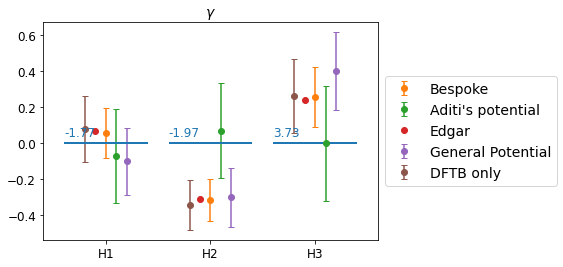

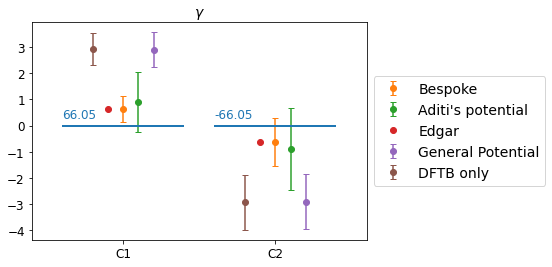

In [34]:
# gamma

title = r'$\gamma$'
poly = "glycine_gamma"

el = 1
fig_H_s, ax_H_s = plt.subplots()

ax_H_s.set_xlim(-0.5 - offset, 2.5 + offset)

ax_H_s.errorbar(shieldings_H, gamma_sh_lmp[el] - shifts[poly][el], yerr= gamma_sh_lmp_err[el], fmt='o' ,color= colors[1], label= "Bespoke", capsize=3)
ax_H_s.errorbar([0,1,2] + offset*np.ones(3), gamma_sh_mlp_aditi[el]- shifts[poly][el], yerr=gamma_sh_mlp_aditi_err[el] ,label= "Aditi's potential", color=colors[2], fmt='o', capsize=3)
ax_H_s.errorbar([0,1,2] - offset*np.ones(3), edgars_results[poly][el]- shifts[poly][el], label= "Edgar", color=colors[3], fmt='o')
ax_H_s.errorbar([0,1,2] + 2*offset*np.ones(3), gamma_sh_mlp[el]- shifts[poly][el], yerr=gamma_sh_mlp_err[el], label= "General Potential", color=colors[4], fmt='o', capsize=3)
ax_H_s.errorbar([0,1,2] - 2*offset*np.ones(3), gamma_sh_mlp_dftb_only[el] - shifts[poly][el], yerr=gamma_sh_mlp_dftb_only_err[el], label= "DFTB only", color=colors[5], fmt='o', capsize=3)

range = ax_H_s.get_ylim()[1] - ax_H_s.get_ylim()[0]
pos = range*percentage_above_line

ax_H_s.hlines(0, -0.5 + offset , 0.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(-0.5 + offset, pos, str(np.round(shifts[poly][el][0], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.hlines(0, 0.5 + offset , 1.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(0.5 + offset, pos, str(np.round(shifts[poly][el][1], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.hlines(0, 1.5 + offset , 2.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(1.5 + offset , pos, str(np.round(shifts[poly][el][2], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.set_title(title, fontsize=title_font)
ax_H_s.legend(fontsize=legend_font, loc='center left', bbox_to_anchor=(1, 0.5))
ax_H_s.tick_params(axis = 'both', which = 'major', labelsize = xtickfont)
ax_H_s.tick_params(axis = 'both', which = 'minor', labelsize = ytickfont)


el = 6
fig_C_s, ax_C_s = plt.subplots()

ax_C_s.set_xlim(-0.5 - offset, 1.5 + offset)

ax_C_s.errorbar(shieldings_C, gamma_sh_lmp[el] - shifts[poly][el], yerr= gamma_sh_lmp_err[el], color= colors[1], label= "Bespoke", fmt='o', capsize=3)
ax_C_s.errorbar([0,1] + offset*np.ones(2), gamma_sh_mlp_aditi[el]- shifts[poly][el], yerr=gamma_sh_mlp_aditi_err[el], label= "Aditi's potential", color=colors[2], fmt='o', capsize=3)
ax_C_s.errorbar([0,1] - offset*np.ones(2), edgars_results[poly][el]- shifts[poly][el], label= "Edgar", color=colors[3], fmt='o', capsize=3)
ax_C_s.errorbar([0,1] + 2*offset*np.ones(2), gamma_sh_mlp[el]- shifts[poly][el], yerr=gamma_sh_mlp_err[el], label= "General Potential", color=colors[4], fmt='o', capsize=3)
ax_C_s.errorbar([0,1] - 2*offset*np.ones(2), gamma_sh_mlp_dftb_only[el]- shifts[poly][el], yerr=gamma_sh_mlp_dftb_only_err[el], label= "DFTB only", color=colors[5], fmt='o', capsize=3)

range = ax_C_s.get_ylim()[1] - ax_C_s.get_ylim()[0]
pos = range*percentage_above_line

ax_C_s.hlines(0, -0.5 + offset , 0.5 - offset , color = colors[0], linewidth = linewidth)
ax_C_s .text(-0.5 + offset, pos, str(np.round(shifts[poly][el][0], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_C_s.hlines(0, 0.5 + offset , 1.5 - offset , color = colors[0], linewidth = linewidth)
ax_C_s .text(0.5 + offset, pos, str(np.round(shifts[poly][el][1], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_C_s.set_title(title, fontsize=title_font)
ax_C_s.legend(fontsize=legend_font, loc='center left', bbox_to_anchor=(1, 0.5))
ax_C_s.tick_params(axis = 'both', which = 'major', labelsize = xtickfont)
ax_C_s.tick_params(axis = 'both', which = 'minor', labelsize = ytickfont)

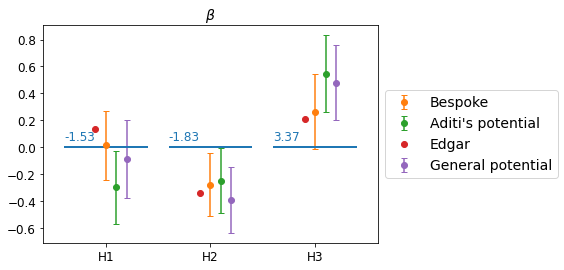

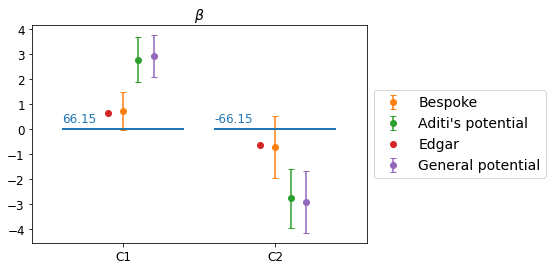

In [42]:
# beta

title = r'$\beta$'
poly = "glycine_beta"

el = 1
fig_H_s, ax_H_s = plt.subplots()

ax_H_s.set_xlim(-0.5 - offset, 2.5 + offset)

ax_H_s.errorbar(shieldings_H, beta_sh_lmp[el] - shifts[poly][el], yerr=beta_sh_lmp_err[el] ,color= colors[1], label= "Bespoke", fmt='o', capsize=3)
ax_H_s.errorbar([0,1,2] + offset*np.ones(3), beta_sh_mlp_aditi[el]- shifts[poly][el], yerr = beta_sh_mlp_aditi_err[el],label= "Aditi's potential", color=colors[2], fmt='o', capsize=3)
ax_H_s.errorbar([0,1,2] - offset*np.ones(3), edgars_results[poly][el]- shifts[poly][el], label= "Edgar", color=colors[3], fmt='o')
ax_H_s.errorbar([0,1,2] + 2*offset*np.ones(3), beta_sh_mlp[el]- shifts[poly][el], yerr = beta_sh_mlp_err[el],label= "General potential", color=colors[4], fmt='o', capsize=3)

range = ax_H_s.get_ylim()[1] - ax_H_s.get_ylim()[0]
pos = range*percentage_above_line

ax_H_s.hlines(0, -0.5 + offset , 0.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(-0.5 + offset, pos, str(np.round(shifts[poly][el][0], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.hlines(0, 0.5 + offset , 1.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(0.5 + offset, pos, str(np.round(shifts[poly][el][1], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.hlines(0, 1.5 + offset , 2.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(1.5 + offset , pos, str(np.round(shifts[poly][el][2], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.set_title(title, fontsize=title_font)
ax_H_s.legend(fontsize=legend_font, loc='center left', bbox_to_anchor=(1, 0.5))
ax_H_s.tick_params(axis = 'both', which = 'major', labelsize = xtickfont)
ax_H_s.tick_params(axis = 'both', which = 'minor', labelsize = ytickfont)


el = 6
fig_C_s, ax_C_s = plt.subplots()

ax_C_s.set_xlim(-0.5 - offset, 1.5 + offset)

ax_C_s.errorbar(shieldings_C, beta_sh_lmp[el] - shifts[poly][el], yerr=beta_sh_lmp_err[el] ,color= colors[1], label= "Bespoke", fmt='o', capsize=3)
ax_C_s.errorbar([0,1] + offset*np.ones(2), beta_sh_mlp_aditi[el]- shifts[poly][el], yerr=beta_sh_mlp_aditi_err[el] ,label= "Aditi's potential", color=colors[2], fmt='o', capsize=3)
ax_C_s.errorbar([0,1] - offset*np.ones(2), edgars_results[poly][el]- shifts[poly][el], label= "Edgar", color=colors[3], fmt='o', capsize=3)
ax_C_s.errorbar([0,1] + 2*offset*np.ones(2), beta_sh_mlp[el]- shifts[poly][el], yerr=beta_sh_mlp_err[el] ,label= "General potential", color=colors[4], fmt='o', capsize=3)

range = ax_C_s.get_ylim()[1] - ax_C_s.get_ylim()[0]
pos = range*percentage_above_line

ax_C_s.hlines(0, -0.5 + offset , 0.5 - offset , color = colors[0], linewidth = linewidth)
ax_C_s .text(-0.5 + offset, pos, str(np.round(shifts[poly][el][0], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_C_s.hlines(0, 0.5 + offset , 1.5 - offset , color = colors[0], linewidth = linewidth)
ax_C_s .text(0.5 + offset, pos, str(np.round(shifts[poly][el][1], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_C_s.set_title(title, fontsize=title_font)
ax_C_s.legend(fontsize=legend_font, loc='center left', bbox_to_anchor=(1, 0.5))
ax_C_s.tick_params(axis = 'both', which = 'major', labelsize = xtickfont)
ax_C_s.tick_params(axis = 'both', which = 'minor', labelsize = ytickfont)

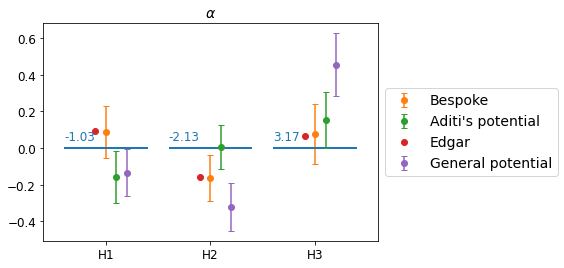

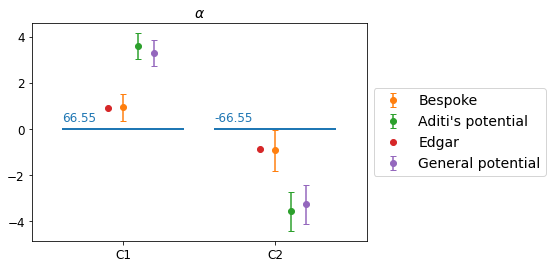

In [45]:
# alpha

title = r'$\alpha$'
poly = "glycine_alpha"

el = 1
fig_H_s, ax_H_s = plt.subplots()

ax_H_s.set_xlim(-0.5 - offset, 2.5 + offset)

ax_H_s.errorbar(shieldings_H, alpha_sh_lmp[el] - shifts[poly][el], yerr=alpha_sh_lmp_err[el] ,color= colors[1], label= "Bespoke", fmt='o', capsize=3)
ax_H_s.errorbar([0,1,2] + offset*np.ones(3), alpha_sh_mlp_aditi[el]- shifts[poly][el], yerr=alpha_sh_mlp_aditi_err[el], label= "Aditi's potential", color=colors[2], fmt='o', capsize=3)
ax_H_s.errorbar([0,1,2] - offset*np.ones(3), edgars_results[poly][el]- shifts[poly][el], label= "Edgar", color=colors[3], fmt='o', capsize=3)
ax_H_s.errorbar([0,1,2] + 2*offset*np.ones(3), alpha_sh_mlp[el]- shifts[poly][el], yerr=alpha_sh_mlp_err[el], label= "General potential", color=colors[4], fmt='o', capsize=3)

range = ax_H_s.get_ylim()[1] - ax_H_s.get_ylim()[0]
pos = range*percentage_above_line

ax_H_s.hlines(0, -0.5 + offset , 0.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(-0.5 + offset, pos, str(np.round(shifts[poly][el][0], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.hlines(0, 0.5 + offset , 1.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(0.5 + offset, pos, str(np.round(shifts[poly][el][1], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.hlines(0, 1.5 + offset , 2.5 - offset , color = colors[0], linewidth = linewidth)
ax_H_s .text(1.5 + offset , pos, str(np.round(shifts[poly][el][2], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_H_s.set_title(title, fontsize=title_font)
ax_H_s.legend(fontsize=legend_font, loc='center left', bbox_to_anchor=(1, 0.5))
ax_H_s.tick_params(axis = 'both', which = 'major', labelsize = xtickfont)
ax_H_s.tick_params(axis = 'both', which = 'minor', labelsize = ytickfont)


el = 6
fig_C_s, ax_C_s = plt.subplots()

ax_C_s.set_xlim(-0.5 - offset, 1.5 + offset)

ax_C_s.errorbar(shieldings_C, alpha_sh_lmp[el] - shifts[poly][el], yerr=alpha_sh_lmp_err[el],  color= colors[1], label= "Bespoke", fmt='o', capsize=3)
ax_C_s.errorbar([0,1] + offset*np.ones(2), alpha_sh_mlp_aditi[el]- shifts[poly][el], yerr=alpha_sh_mlp_aditi_err[el], label= "Aditi's potential", color=colors[2], fmt='o', capsize=3)
ax_C_s.errorbar([0,1] - offset*np.ones(2), edgars_results[poly][el]- shifts[poly][el],label= "Edgar", color=colors[3], fmt='o', capsize=3)
ax_C_s.errorbar([0,1] + 2*offset*np.ones(2), alpha_sh_mlp[el]- shifts[poly][el], yerr=alpha_sh_mlp_err[el], label= "General potential", color=colors[4], fmt='o', capsize=3)

range = ax_C_s.get_ylim()[1] -ax_C_s.get_ylim()[0]
pos = range*percentage_above_line

ax_C_s.hlines(0, -0.5 + offset , 0.5 - offset , color = colors[0], linewidth = linewidth)
ax_C_s .text(-0.5 + offset, pos, str(np.round(shifts[poly][el][0], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_C_s.hlines(0, 0.5 + offset , 1.5 - offset , color = colors[0], linewidth = linewidth)
ax_C_s .text(0.5 + offset, pos, str(np.round(shifts[poly][el][1], 2)) , ha ='left', va ='center', color = colors[0], fontsize = text_font)

ax_C_s.set_title(title, fontsize=title_font)
ax_C_s.legend(fontsize=legend_font, loc='center left', bbox_to_anchor=(1, 0.5))
ax_C_s.tick_params(axis = 'both', which = 'major', labelsize = xtickfont)
ax_C_s.tick_params(axis = 'both', which = 'minor', labelsize = ytickfont)

In [ ]:
# 
shieldings_H = ["H1","H2", "H3"]
shieldings_C = ["C1", "C2"]

fig, ax = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(18)

el = 1
for i in range(3):
    ax[i].scatter(shieldings_H[i], shifts["glycine_gamma"][el][i], label= "exp", marker="x", s=100, color=colors[0])
    ax[i].scatter(shieldings_H[i], gamma_sh_lmp[el][i], label= "Bespoke", color=colors[1])
    ax[i].scatter(shieldings_H[i], gamma_sh_mlp_aditi[el][i], label= "Aditi's potential", color=colors[2])
    ax[i].scatter(shieldings_H[i], edgars_results["glycine_gamma"][el][i], label= "Edgar", color=colors[3])
    ax[i].scatter(shieldings_H[i], gamma_sh_mlp_dftb_only[el][i], label= "DFTB only", color=colors[4])

ax[2].legend()

fig_C, ax_C = plt.subplots(ncols=2, nrows=1)
fig_C.set_figheight(4)
fig_C.set_figwidth(12)


el = 6
for i in range(2):
    ax_C[i].scatter(shieldings_C[i], shifts["glycine_gamma"][el][i], label= "exp", marker="x", s=100, color=colors[0])
    ax_C[i].scatter(shieldings_C[i], gamma_sh_lmp[el][i], label= "Bespoke", color=colors[1])
    ax_C[i].scatter(shieldings_C[i], gamma_sh_mlp_aditi[el][i], label= "Aditi's potential", color=colors[2])
    ax_C[i].scatter(shieldings_C[i], edgars_results["glycine_gamma"][el][i], label= "Edgar", color=colors[3])
    ax_C[i].scatter(shieldings_C[i], gamma_sh_mlp_dftb_only[el][i], label= "DFTB only", color=colors[4])

ax_C[1].legend()

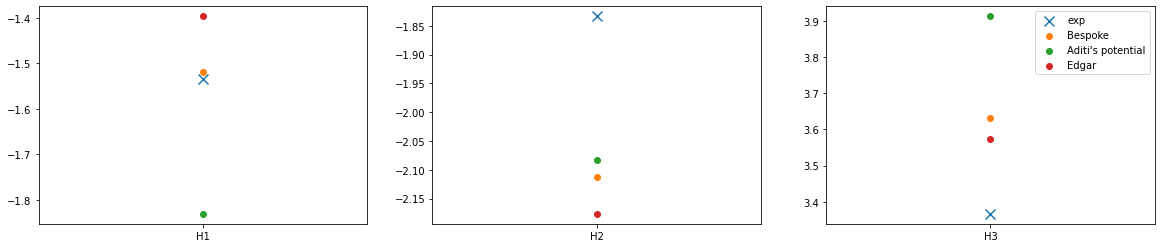

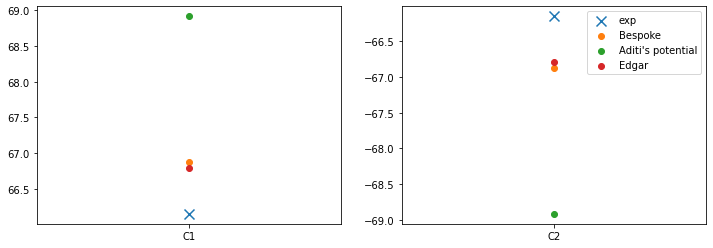

In [82]:
# beta
shieldings = ["H1","H2", "H3"]
shieldings_C = ["C1", "C2"]

fig, ax = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(20)


el = 1
for i in range(3):
    ax[i].scatter(shieldings[i], shifts["glycine_beta"][el][i], label= "exp", marker="x", s=100, color=colors[0])
    ax[i].scatter(shieldings[i], beta_sh_lmp[el][i], label= "Bespoke", color=colors[1])
    ax[i].scatter(shieldings[i], beta_sh_mlp_aditi[el][i], label= "Aditi's potential", color=colors[2])
    ax[i].scatter(shieldings[i], edgars_results["glycine_beta"][el][i], label= "Edgar", color=colors[3])

plt.legend()

fig_C, ax_C = plt.subplots(ncols=2, nrows=1)
fig_C.set_figheight(4)
fig_C.set_figwidth(12)


el = 6
for i in range(2):
    ax_C[i].scatter(shieldings_C[i], shifts["glycine_beta"][el][i], label= "exp", marker="x", s=100, color=colors[0])
    ax_C[i].scatter(shieldings_C[i], beta_sh_lmp[el][i], label= "Bespoke", color=colors[1])
    ax_C[i].scatter(shieldings_C[i], beta_sh_mlp_aditi[el][i], label= "Aditi's potential", color=colors[2])
    ax_C[i].scatter(shieldings_C[i], edgars_results["glycine_beta"][el][i], label= "Edgar", color=colors[3])

ax_C[1].legend()

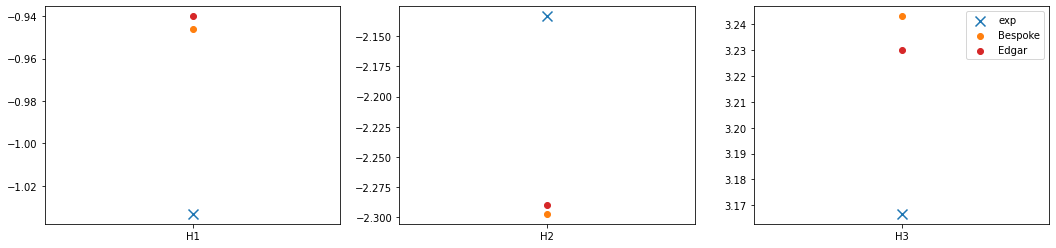

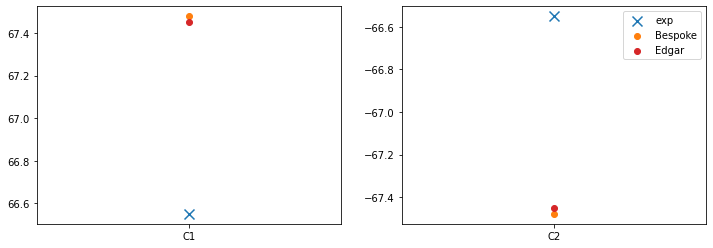

In [83]:
# alpha
shieldings = ["H1","H2", "H3"]
shieldings_C = ["C1", "C2"]

fig, ax = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(4)
fig.set_figwidth(18)

el = 1
for i in range(3):
    ax[i].scatter(shieldings[i], shifts["glycine_alpha"][el][i], label= "exp", marker="x", s=100, color=colors[0])
    ax[i].scatter(shieldings[i], alpha_sh_lmp[el][i], label= "Bespoke", color=colors[1])
    #ax[i].scatter(shieldings[i], alpha_sh_mlp_aditi[el][i], label= "Aditi's potential", color=colors[2])
    ax[i].scatter(shieldings[i], edgars_results["glycine_alpha"][el][i], label= "Edgar", color=colors[3])

plt.legend()

fig_C, ax_C = plt.subplots(ncols=2, nrows=1)
fig_C.set_figheight(4)
fig_C.set_figwidth(12)

el = 6
for i in range(2):
    ax_C[i].scatter(shieldings_C[i], shifts["glycine_alpha"][el][i], label= "exp", marker="x", s=100, color=colors[0])
    ax_C[i].scatter(shieldings_C[i], alpha_sh_lmp[el][i], label= "Bespoke", color=colors[1])
    #ax_C[i].scatter(shieldings_C[i], alpha_sh_mlp_aditi[el][i], label= "Aditi's potential", color=colors[2])
    ax_C[i].scatter(shieldings_C[i], edgars_results["glycine_alpha"][el][i], label= "Edgar", color=colors[3])

ax_C[1].legend()